In [1]:
import bilby
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
outdir = 'outdir'
label = 'create_your_own_source_model'
sampling_frequency = 4096
duration = 1


In [3]:
def sine_gaussian(f, A, f0, tau, phi0, geocent_time, ra, dec, psi):
    arg = -(np.pi * tau * (f - f0))**2 + 1j * phi0
    plus = np.sqrt(np.pi) * A * tau * np.exp(arg) / 2.
    cross = plus * np.exp(1j * np.pi / 2)
    return {'plus': plus, 'cross': cross}


In [4]:
#testing
#sine_gaussian(np.arange(0,100,1), A=1e-23, f0=100, tau=1, phi0=0, geocent_time=0,ra=0, dec=0, psi=0)

In [5]:
# We now define some parameters that we will inject
injection_parameters = dict(A=5.0*1e-23, f0=100, tau=1, phi0=0, geocent_time=1126259600.,
                            ra=0, dec=0, psi=0)


In [6]:
# Now we pass our source function to the WaveformGenerator
waveform_generator = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=sine_gaussian)


12:45 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: __main__.sine_gaussian
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [7]:
# Set up interferometers.
ifos = bilby.gw.detector.InterferometerList(['H1', 'L1'])
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=injection_parameters['geocent_time'] - 3)
ifos.inject_signal(waveform_generator=waveform_generator,
                   parameters=injection_parameters)


/home/hemantakumar.phurailatpam/anaconda3/envs/bilby/lib/python3.7/site-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
12:45 bilby WARNING : Injecting signal outside segment, start_time=1126259597.0, merger time=1126259600.0.
12:45 bilby INFO    : Injected signal in H1:
12:45 bilby INFO    :   optimal SNR = 15.05
12:45 bilby INFO    :   matched filter SNR = 14.80-1.37j
12:45 bilby INFO    :   A = 4.9999999999999997e-23
12:45 bilby INFO    :   f0 = 100
12:45 bilby INFO    :   tau = 1
12:45 bilby INFO    :   phi0 = 0
12:45 bilby INFO    :   geocent_time = 1126259600.0
12:45 bilby INFO    :   ra = 0
12:45 bilby INFO    :   dec = 0
12:45 bilby INFO    :   psi = 0
12:45 bilby WARNING : Injecting signal outside segment, start_time=1126259597.0, merger time=1126259600.0.
12:45 bilby INFO    : Injected signal in L1:
12:45 bilby INFO    :   optim

[{'plus': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]),
  'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])},
 {'plus': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]),
  'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])}]

12:45 bilby WARNING : Injecting signal outside segment, start_time=1126259597.0, merger time=1126259600.0.
12:45 bilby INFO    : Injected signal in H1:
12:45 bilby INFO    :   optimal SNR = 15.05
12:45 bilby INFO    :   matched filter SNR = 29.85-1.37j
12:45 bilby INFO    :   A = 4.9999999999999997e-23
12:45 bilby INFO    :   f0 = 100
12:45 bilby INFO    :   tau = 1
12:45 bilby INFO    :   phi0 = 0
12:45 bilby INFO    :   geocent_time = 1126259600.0
12:45 bilby INFO    :   ra = 0
12:45 bilby INFO    :   dec = 0
12:45 bilby INFO    :   psi = 0
12:45 bilby WARNING : Injecting signal outside segment, start_time=1126259597.0, merger time=1126259600.0.
12:45 bilby INFO    : Injected signal in L1:
12:45 bilby INFO    :   optimal SNR = 14.60
12:45 bilby INFO    :   matched filter SNR = 28.96+1.41j
12:45 bilby INFO    :   A = 4.9999999999999997e-23
12:45 bilby INFO    :   f0 = 100
12:45 bilby INFO    :   tau = 1
12:45 bilby INFO    :   phi0 = 0
12:45 bilby INFO    :   geocent_time = 1126259600

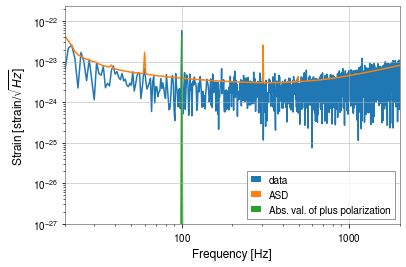

In [8]:
#to plot the frequency domain  
injection = ifos.inject_signal(waveform_generator=waveform_generator,
                   parameters=injection_parameters)

H1 = ifos[0]
H1_injection = injection[0]

fig, ax = plt.subplots()
idxs = H1.strain_data.frequency_mask  # This is a boolean mask of the frequencies which we'll use in the analysis
ax.loglog(H1.strain_data.frequency_array[idxs],
          np.abs(H1.strain_data.frequency_domain_strain[idxs]),
          label="data")
ax.loglog(H1.frequency_array[idxs],
          H1.amplitude_spectral_density_array[idxs],
          label="ASD")
ax.loglog(H1.frequency_array[idxs],
          np.abs(H1_injection["plus"][idxs]),
          label="Abs. val. of plus polarization")

'''L1 = ifos[1]
L1_injection = injection[1]

ax.loglog(L1.frequency_array[idxs]+5,
          L1.amplitude_spectral_density_array[idxs],
          label="ASD")'''

ax.set_xlim(20,2000)
ax.set_ylim(1e-27,2.327737159425905e-22)


ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
ax.legend()
plt.show()

In [9]:
# Here we define the priors for the search. We use the injection parameters
# except for the amplitude, f0, and geocent_time
prior = injection_parameters.copy()
#prior['A'] = bilby.core.prior.LogUniform(minimum=1e-25, maximum=1e-21, name='A')
prior['A'] = bilby.core.prior.Uniform(minimum=1.0*1e-23, maximum=10.0*1e-23, name='A')
prior['f0'] = bilby.core.prior.Uniform(90, 110, 'f')

likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers=ifos, waveform_generator=waveform_generator)


In [10]:
'''
import smtplib
from email.message import EmailMessage

def email_alert(subject, body, to):
    msg =  EmailMessage()
    msg.set_content(body)
    msg['subject'] = subject
    msg['to'] = to
    
    
    user = "hemantaphurailatpam@gmail.com"
    msg['from'] = user
    password = "syrgxspjntbuzyoz"
    
    server = smtplib.SMTP("smtp.gmail.com", 587)
    server.starttls()
    server.login(user, password)
    server.send_message(msg)
    
    server.quit()
'''    

'\nimport smtplib\nfrom email.message import EmailMessage\n\ndef email_alert(subject, body, to):\n    msg =  EmailMessage()\n    msg.set_content(body)\n    msg[\'subject\'] = subject\n    msg[\'to\'] = to\n    \n    \n    user = "hemantaphurailatpam@gmail.com"\n    msg[\'from\'] = user\n    password = "syrgxspjntbuzyoz"\n    \n    server = smtplib.SMTP("smtp.gmail.com", 587)\n    server.starttls()\n    server.login(user, password)\n    server.send_message(msg)\n    \n    server.quit()\n'

In [11]:
result = bilby.core.sampler.run_sampler(
    likelihood, prior, sampler='dynesty', outdir=outdir, label=label,
    resume=False, sample='unif', injection_parameters=injection_parameters, npool=4)


'''
if __name__ == '__main__':
    email_alert("bilby", "running code got completed", "hemantaphurailatpam@outlook.com")
'''

12:46 bilby INFO    : Running for label 'create_your_own_source_model', output will be saved to 'outdir'
12:46 bilby INFO    : Using lal version 7.1.2
12:46 bilby INFO    : Using lal git version Branch: None;Tag: lalsuite-v6.82;Id: cf792129c2473f42ce6c6ee21d8234254cefd337;;Builder: Unknown User <>;Repository status: UNCLEAN: Modified working tree
12:46 bilby INFO    : Using lalsimulation version 2.5.1
12:46 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsuite-v6.82;Id: cf792129c2473f42ce6c6ee21d8234254cefd337;;Builder: Unknown User <>;Repository status: UNCLEAN: Modified working tree
12:46 bilby INFO    : Search parameters:
12:46 bilby INFO    :   A = Uniform(minimum=1e-23, maximum=9.999999999999999e-23, name='A', latex_label='A', unit=None, boundary=None)
12:46 bilby INFO    :   f0 = Uniform(minimum=90, maximum=110, name='f', latex_label='f', unit=None, boundary=None)
12:46 bilby INFO    :   tau = 1
12:46 bilby INFO    :   phi0 = 0
12:46 bilby INFO    :   geocent

0it [00:00, ?it/s]

12:46 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'unif', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 1000, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 4, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 600, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7fc8daf5c390>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
12:46 bilby INFO    : Checkpoint every check_point_delta_t = 600s
12:46 bilby INFO    : Using dynesty version 1.0.1
12:46 bilby INFO    : Generating initial points from the pri

10827it [00:38, 359.24it/s, bound:35 nc:  1 ncall:5.6e+04 eff:19.4% logz-ratio=856.16+/-0.13 dlogz:0.104>0.1]

12:46 bilby INFO    : Written checkpoint file outdir/create_your_own_source_model_resume.pickle
12:46 bilby INFO    : Writing 2235 current samples to outdir/create_your_own_source_model_samples.dat
/home/hemantakumar.phurailatpam/anaconda3/envs/bilby/lib/python3.7/site-packages/dynesty/plotting.py:179: RuntimeWarning: overflow encountered in exp
  data = [nlive, np.exp(logl), np.exp(logwt), np.exp(logz)]
/home/hemantakumar.phurailatpam/anaconda3/envs/bilby/lib/python3.7/site-packages/dynesty/plotting.py:203: RuntimeWarning: overflow encountered in exp
  zspan = (0., 1.05 * np.exp(logz[-1] + 3. * logzerr[-1]))
12:46 bilby WARNING : Axis limits cannot be NaN or Inf
12:46 bilby WARNING : Failed to create dynesty run plot at checkpoint
12:46 bilby INFO    : Starting to close worker pool.
12:46 bilby INFO    : Finished closing worker pool.


10860it [00:46, 234.69it/s, bound:35 nc:  1 ncall:5.6e+04 eff:21.2% logz-ratio=856.26+/-0.12 dlogz:0.000>0.1]



12:47 bilby INFO    : Sampling time: 0:00:36.279361
12:47 bilby INFO    : Summary of results:
nsamples: 11860
ln_noise_evidence: -5008.629
ln_evidence: -4152.367 +/-  0.124
ln_bayes_factor: 856.262 +/-  0.124



'\nif __name__ == \'__main__\':\n    email_alert("bilby", "running code got completed", "hemantaphurailatpam@outlook.com")\n'

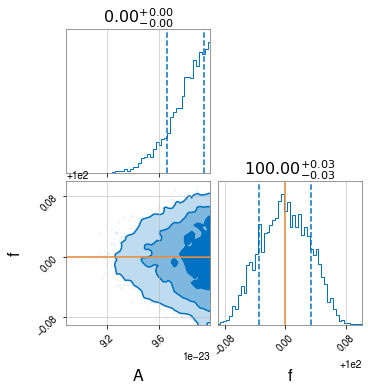

In [12]:
result.plot_corner()

In [13]:
#chirp mass
m1_ = 10.
m2_ = 10.
((m1_*m2_)**(3/5))/((m1_+m2_)**(1/5))

8.705505632961241

In [15]:
m2_/m1_

1.0